In [50]:
pip install sklearn


[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=3a942b566cc929f47feaaa1da41a607ef1bae52d85bd6008f32556cb7946749b
  Stored in directory: c:\users\anatoly\appdata\local\pip\cache\wheels\42\56\cc\4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [51]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings(action='ignore')

####  1. Выберите подвыборку с основными переменными для дальнейшего анализа.

In [52]:
path = "salary_data.csv"
source_df = pd.read_csv(path, engine="python", delimiter=";")
source_df = source_df.loc[source_df["ID"] < 10000]
source_df.head(len(source_df))

,ID,income,age,gender,education_level
2,1996,82606.214973,22,M,2.0
3,9366,81551.229988,36,M,2.0
4,9733,79593.253224,51,M,1.0
27,5972,74374.283991,26,M,1.0
37,2980,73572.547007,31,F,3.0
...,...,...,...,...,...
99967,5555,15000.000000,31,F,0.0
99973,951,15000.000000,30,F,1.0
99976,7413,15000.000000,23,M,2.0
99977,4235,15000.000000,36,M,1.0


Columns:
1. ID - Identifier of the candidate
2. incomde - The annual income declared by the person
3. age - Age of the person at the moment of the test
4. gender - Gender declared by the person
5. education_level - Education level declared by the user (0: primary complete, 1: secondary complete, 2: tertiary complete, 3: post


In [53]:
# стоит ли группировать по возрасту?
criteria = "ID"

def mean_amount_by_empl(df):
    df_empl = df.groupby(criteria, as_index=False).agg({"income": "mean"})
    df_empl = df_empl.sort_values("income", ascending=False)

    return df_empl

df_empl = mean_amount_by_empl(source_df)
df_empl.head()

,ID,income
7580,7580,111059.672798
7958,7958,110033.820101
3116,3116,106548.464433
2617,2617,106168.331983
1815,1815,105905.391492


In [54]:
count_empl = len(df_empl)
income_total = df_empl["income"].sum()

print("number of employees: {}".format(count_empl))
print("total income: {}".format(int(income_total)))

number of employees: 10000
total income: 405563863


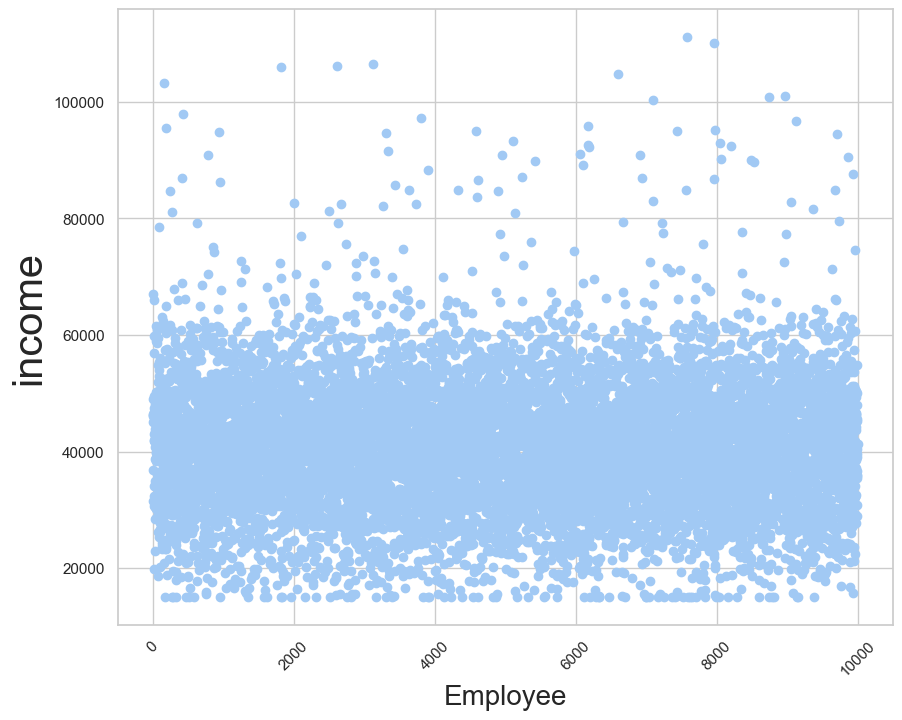

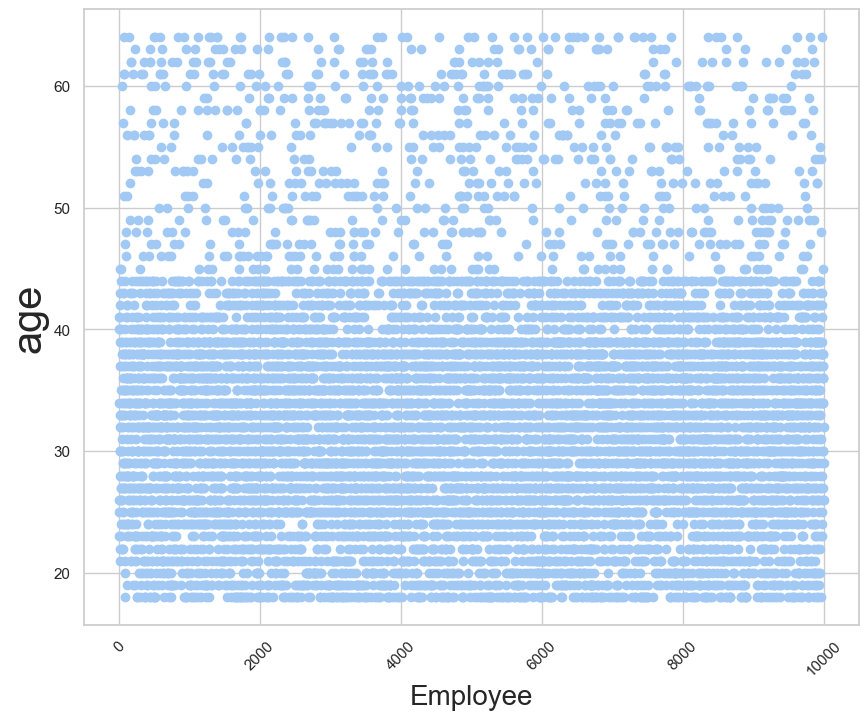

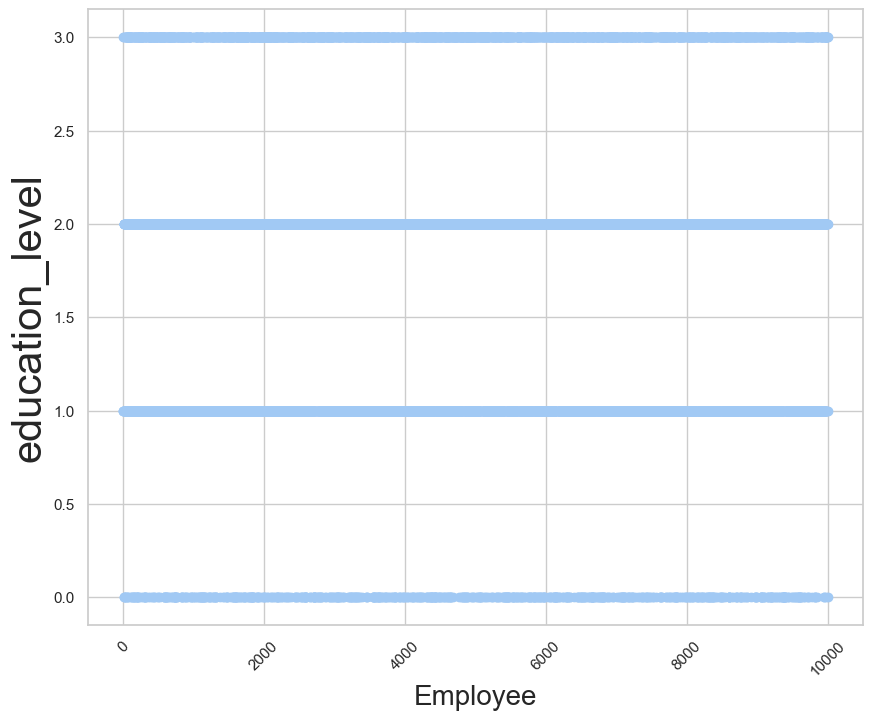

In [55]:
from matplotlib import pyplot as plt

def data_image(name):
    plt.figure(figsize=(10, 8))
    plt.scatter(source_df[criteria], source_df[name])
    plt.xticks(rotation=45)

    plt.xlabel(f"Employee", fontsize=20)
    plt.ylabel(name, fontsize=30)
    
data_image("income")
data_image("age")
data_image("education_level")



#### 2. Непараметрическая оценка плотности распределения в виде гистограммы с использованием функции плотности ядра

In [56]:
def cut_tails(array, min_value=5, max_value=95):
    array_cut = []
    q95, q05 = np.percentile(array, [max_value, min_value])
    interval = q95 - q05
    
    min_dist = q05 - (1.5 * interval)
    max_dist = q95 + (1.5 * interval)
    
    for data in array:
        if data < max_dist and data > min_dist:
            array_cut.append(data)
    return array_cut

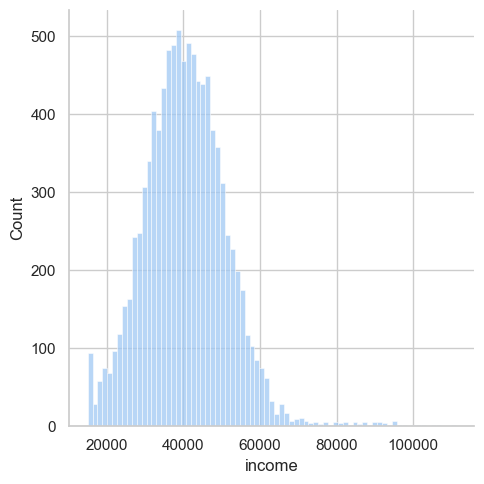

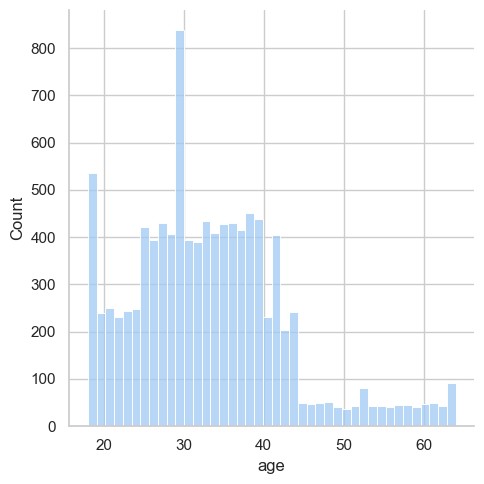

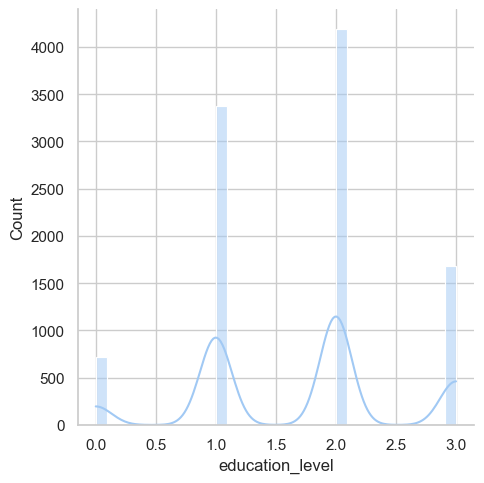

In [57]:
import seaborn as sns

sns.displot(source_df["income"], kde=False)
sns.displot(source_df["age"], kde=False)
sns.displot(source_df["education_level"], kde=True)

In [58]:

mean = df_empl["income"].mean()
var = df_empl["income"].var()
std = df_empl["income"].std()
median = df_empl["income"].median()

trunk_mean = scipy.stats.trim_mean(df_empl["income"], proportiontocut=0.1)

def mad(df):
    sigma = 1.2
    k = scipy.stats.lognorm.ppf(3/4., s=sigma)
    median = df.median()

    return k * np.median(np.fabs(df - median))

mad_value = mad(df_empl["income"])
print(f'Average Income Size: Average = {int(mean)}, variance = {int(var)}, standard deviation = {int(std)},\n'
      f'median = {int(median)}, truncated mean {int(trunk_mean)}, MAD = {int(mad_value)}')


mean = source_df["age"].mean()
var = source_df["age"].var()
std = source_df["age"].std()
median = source_df["age"].median()

mad_value = mad(source_df["age"])
print(f'Average Age: Average = {int(mean)}, variance = {int(var)}, standard deviation = {int(std)},\n'
      f'median = {int(median)}, truncated mean {int(trunk_mean)}, MAD = {int(mad_value)}')

Average Income Size: Average = 40556, variance = 119947698, standard deviation = 10952,
median = 40207, truncated mean 40268, MAD = 15568
Average Age: Average = 33, variance = 91, standard deviation = 9,
median = 32, truncated mean 40268, MAD = 13


In [59]:


def sample_mean(df_empl, name):
      norm_q95 = scipy.stats.norm.ppf(0.95)
      mean_conf = norm_q95 * std / np.sqrt(len(df_empl))

      chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(df_empl) - 1)
      chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(df_empl) - 1)

      var_conf_left = var * (len(df_empl) - 1) / chi2_q95_left
      var_conf_right = var * (len(df_empl) - 1) / chi2_q95_right

      std_conf_left = np.sqrt(var_conf_left)
      std_conf_right = np.sqrt(var_conf_right)

      print(name, "Sample mean: %0.3f +/- %0.3f" % (mean, mean_conf))
      print(name, "95%% Confidence interval of sample variance : (%0.3f; %0.3f)"
            % (var_conf_left, var_conf_right))
      print(name, "95%% Confidence interval of sample standard deviation: (%0.3f; %0.3f)"
            % (std_conf_left, std_conf_right))

sample_mean(source_df["income"], "income")
sample_mean(source_df["age"], "age")

income Sample mean: 33.187 +/- 0.157
income 95% Confidence interval of sample variance : (88.902; 93.970)
income 95% Confidence interval of sample standard deviation: (9.429; 9.694)
age Sample mean: 33.187 +/- 0.157
age 95% Confidence interval of sample variance : (88.902; 93.970)
age 95% Confidence interval of sample standard deviation: (9.429; 9.694)


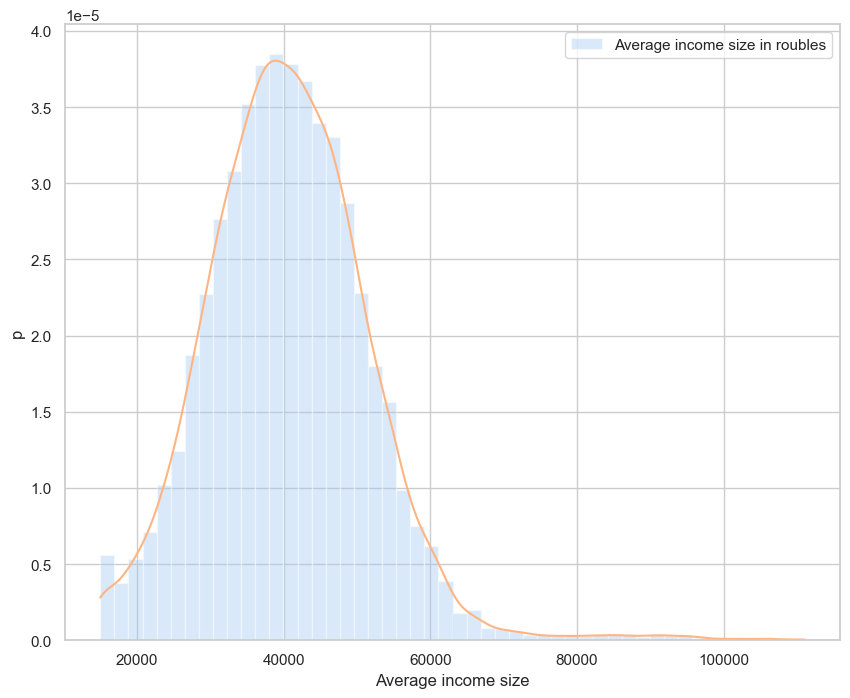

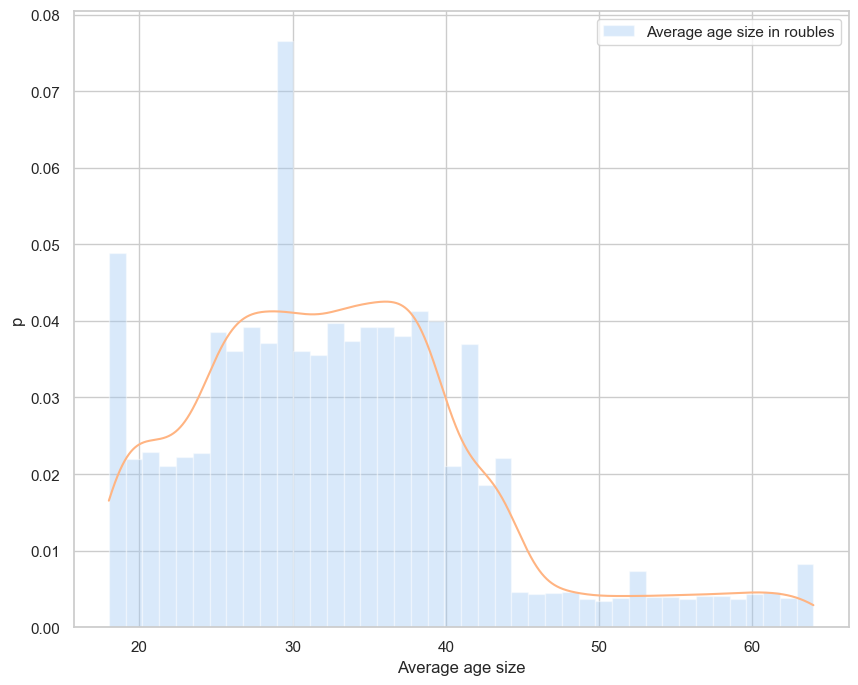

In [60]:
def kern(df_empl, name):
    plt.figure(figsize=(10, 8))

    kernel = scipy.stats.gaussian_kde(df_empl)

    min_price, max_price = df_empl.min(), df_empl.max()
    x = np.linspace(min_price, max_price, len(df_empl))
    kde_values = kernel.evaluate(x)

    sns.distplot(df_empl, kde=False, norm_hist=True, label=f"Average {name} size in roubles")
    plt.plot(x, kde_values)

    plt.ylabel("p")
    plt.xlabel(f"Average {name} size")
    plt.legend()
    plt.show()


kern(source_df["income"], "income")
kern(source_df["age"], "age")
# kern(source_df["education_level"], "education_level")

<AxesSubplot:xlabel='education_level', ylabel='Density'>

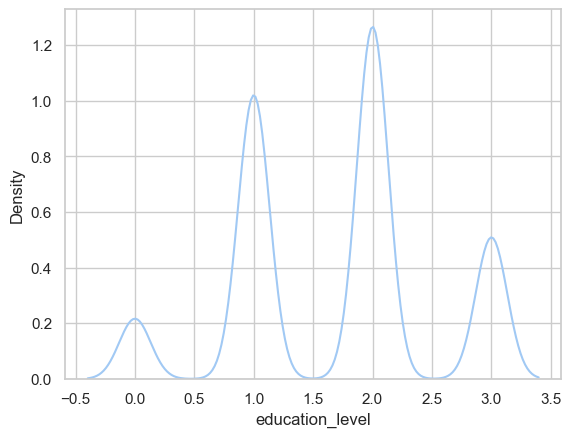

In [61]:
sns.kdeplot(source_df["education_level"])

#### 3. Вам необходимо провести оценку порядковых статистик и представить их в виде “ящиков с усами”.

      ID        income  age gender  education_level
2   1996  82606.214973   22      M              2.0
3   9366  81551.229988   36      M              2.0
4   9733  79593.253224   51      M              1.0
27  5972  74374.283991   26      M              1.0
37  2980  73572.547007   31      F              3.0


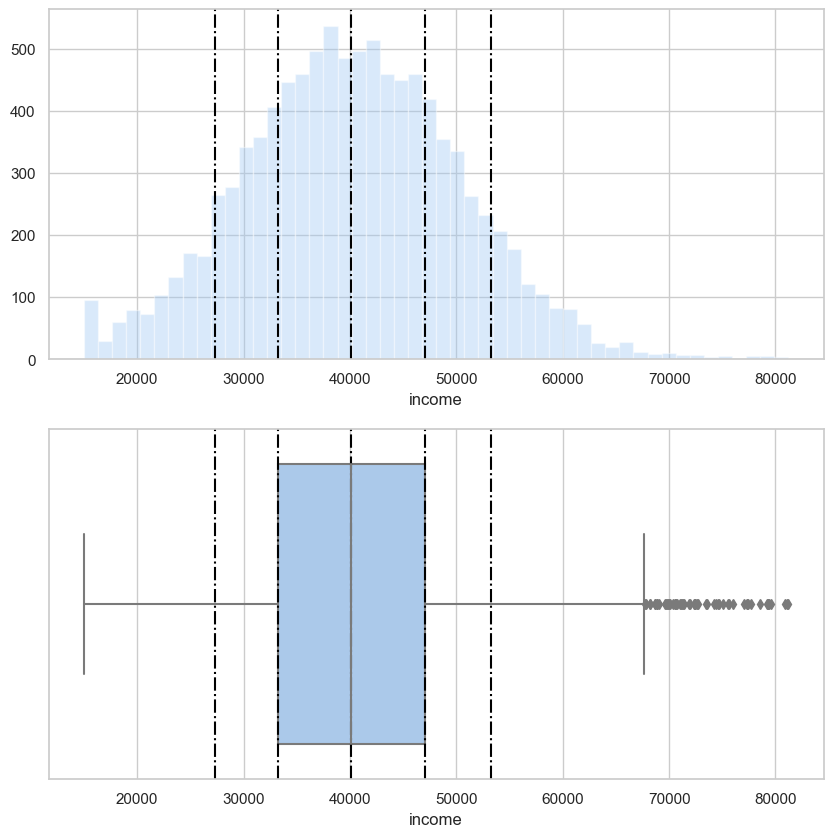

In [62]:
def quantiles(array):
    return np.array([np.quantile(array, percent) for percent in [0.1, 0.25, 0.5, 0.75, 0.9]])


def plot_box(array, label):
    figure, ax = plt.subplots(2, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    histplot = sns.distplot(array, ax=ax[0], kde=False)
    boxplot = sns.boxplot(x=array, ax=ax[1])

    histplot.set(xlabel=label)
    boxplot.set(xlabel=label)

    for quiantile in quantiles(array):
        ax[0].axvline(quiantile, color='black', linestyle='-.')
        ax[1].axvline(quiantile, color='black', linestyle='-.')
    
    plt.show()


print(source_df.head())
plot_box(cut_tails(source_df.income, 10, 80), 'income')

In [63]:
pd.Series(cut_tails(source_df.income, 10, 80)).describe()

count     9940.000000
mean     40246.643055
std      10215.283712
min      15000.000000
25%      33262.363930
50%      40120.799897
75%      47035.402165
max      81221.385070
dtype: float64

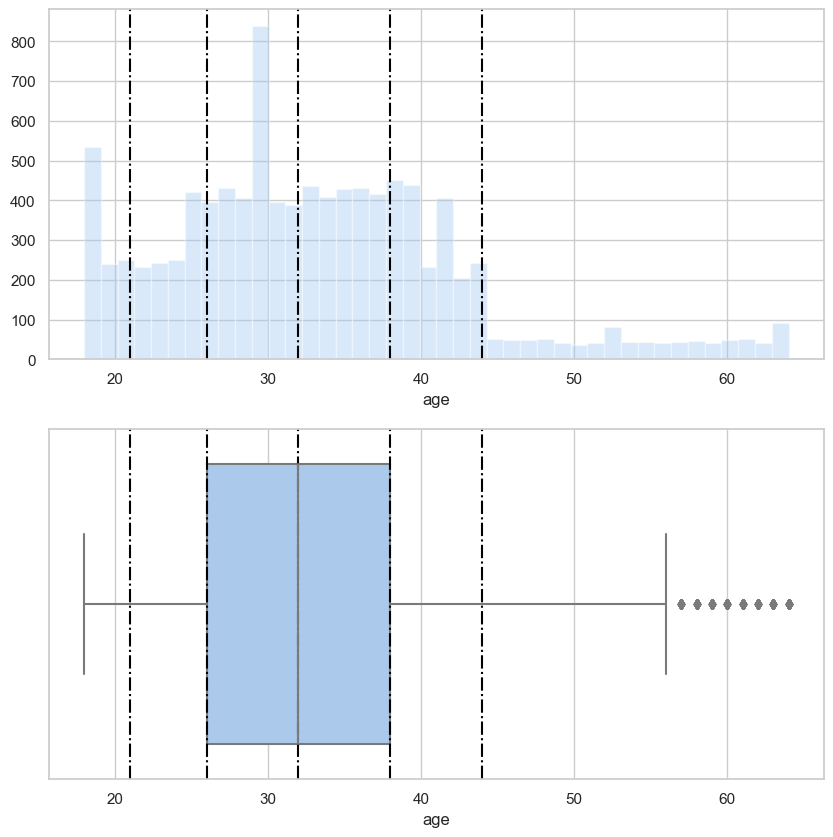

In [64]:
plot_box(cut_tails(source_df.age, 10, 90), 'age')

In [65]:
print(quantiles(source_df.age))
pd.Series(cut_tails(source_df.age, 10, 80)).describe()


[21. 26. 32. 38. 44.]


count    10000.000000
mean        33.186700
std          9.559466
min         18.000000
25%         26.000000
50%         32.000000
75%         38.000000
max         64.000000
dtype: float64

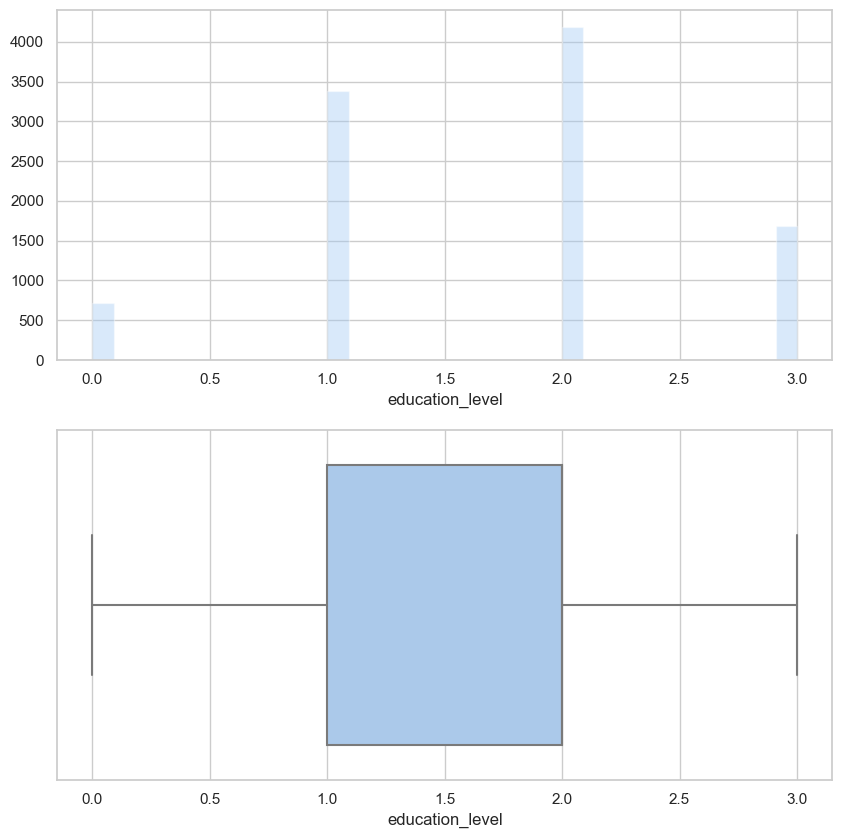

In [66]:
def plot_box(array, label):
    figure, ax = plt.subplots(2, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    histplot = sns.distplot(array, ax=ax[0], kde=False)
    boxplot = sns.boxplot(x=array, ax=ax[1])

    histplot.set(xlabel=label)
    boxplot.set(xlabel=label)
    
    plt.show()

plot_box(source_df.education_level, "education_level")

#### 4. Найдите одно или несколько теоретических распределений, которые могли бы описать вашу выборку на основе результатов непараметрического анализа.

In [67]:
methods = {type(d).__name__ : d for d in [
                    scipy.stats.norm, scipy.stats.alpha, scipy.stats.gamma,
                    scipy.stats.beta
                    ]}

def distplot(array, label):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    subplot = sns.distplot(array, kde=True)
    subplot.set(xlabel=label)


    for name, method in methods.items():
        x_plot = np.linspace(np.min(array), np.max(array), 100)
        args = method.fit(array)
        print(args)
        print("Method: ", name, "args: ", args)
        y_plot = method.pdf(x_plot, *args)
        
        sns.lineplot(x=x_plot, y=y_plot, label=name)
        plt.legend()

(40207.00172674355, 10143.145293365507)
Method:  norm_gen args:  (40207.00172674355, 10143.145293365507)
(12.930726305003631, -91914.86216921857, 1699476.4283903725)
Method:  alpha_gen args:  (12.930726305003631, -91914.86216921857, 1699476.4283903725)
(468.7507157030225, -179405.44473424563, 468.5058385805729)
Method:  gamma_gen args:  (468.7507157030225, -179405.44473424563, 468.5058385805729)
(34.6479429251134, 54.024040504282794, -36722.013365157516, 196878.33044626884)
Method:  beta_gen args:  (34.6479429251134, 54.024040504282794, -36722.013365157516, 196878.33044626884)


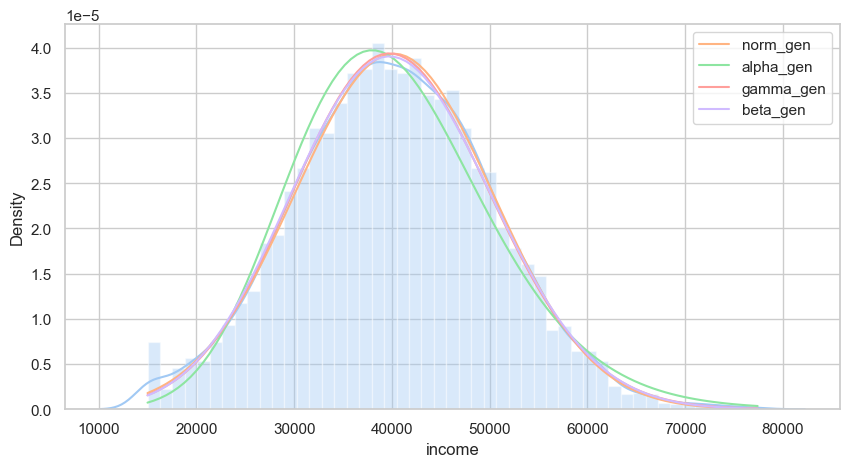

In [68]:
distplot(cut_tails(source_df.income, 15, 80), "income")


(33.02874660769927, 9.3247319553874)
Method:  norm_gen args:  (33.02874660769927, 9.3247319553874)
(7.346900595674427, -32.027149793513004, 468.8013497177601)
Method:  alpha_gen args:  (7.346900595674427, -32.027149793513004, 468.8013497177601)
(4.675724630829546, 12.513164472057648, 4.387679990453634)
Method:  gamma_gen args:  (4.675724630829546, 12.513164472057648, 4.387679990453634)
(1.9669377543090543, 6.022351132663424, 16.70690375384745, 66.2055093905685)
Method:  beta_gen args:  (1.9669377543090543, 6.022351132663424, 16.70690375384745, 66.2055093905685)


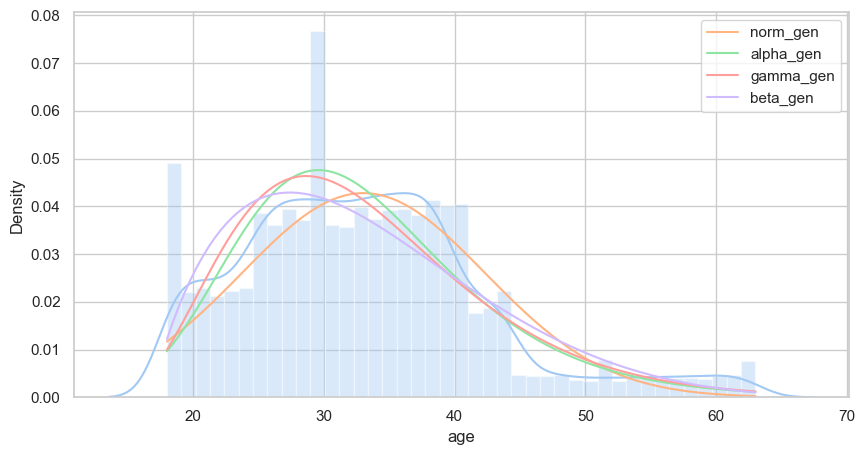

In [69]:
distplot(cut_tails(source_df.age, 5, 70), "age")

#### 5. Оценить параметры выбранных распределений, используя методы максимального правдоподобия и метод наименьших квадратов.

In [92]:
def bfd(data, name, method):
    income_df = data
    # age_df = cut_tails(source_df.age, 15, 80)
    quantiles = np.linspace(0, 1, 50)[1:-1]
    # for norm distribute
    mle = method.fit(income_df, method='MLE')

    ydata, xdata = np.histogram(income_df, bins=100, density=True) #  исходное распределение
    xdata = (xdata + np.roll(xdata, -1))[:-1] / 2.0
    distribution = getattr(scipy.stats, name)
    params = distribution.fit(income_df)
    
    data = pd.Series(data)
    
    x0 = [1, 1]
    ls = scipy.optimize.minimize(
        fun=lambda params: np.square(data.quantile(quantiles).values - method(*params).ppf(quantiles),).sum(),
        x0 = x0
    )

    
    return f"least squares: {ls.x}, likehood {mle}"
# def func(x, a, b): # нормальное распределение
#     return getattr(scipy.stats.distributions, 'beta').pdf(x, a, b)

                

for name, method in methods.items():
    print(name, bfd(cut_tails(source_df.income, 15, 80),name[:-4], method))

for name, method in methods.items():
    print(name, bfd(cut_tails(source_df.age, 15, 80),name[:-4], method))
    
    

# d_distplot(source_df.education_level, "education_level")
# # # for name, method in dic_methods.items():
# # #     print(name, bfd(source_df.education_level, name[:-4], method))
    


norm_gen least squares: [40165.32759982 10156.13629552], likehood (40207.00172674355, 10143.145293365507)
alpha_gen least squares: [-905.99957895  497.99511203], likehood (12.930726305003631, -91914.86216921857, 1699476.4283903725)
gamma_gen least squares: [-1749303.26896937  5901702.70623779], likehood (468.7507157030225, -179405.44473424563, 468.5058385805729)
beta_gen least squares: [  984.38466889 -1786.25228208], likehood (34.6479429251134, 54.024040504282794, -36722.013365157516, 196878.33044626884)


#### 6. Проверьте оцененные параметры с помощью графика квантиль-квантиль (QQ).

In [81]:
def biplot(array, method):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sns.set_theme(style='whitegrid', palette='pastel')

    args = method.fit(array)
    print(f"({type(method).__name__})args: ", args)
    scipy.stats.probplot(array, dist=method, sparams=(args), plot=ax) # сравнение реального распределения данных с распределением method

    ax.get_lines()[0].set_marker('.')
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    plt.show()

(norm_gen)args:  (40157.24175536075, 10063.293583534713)


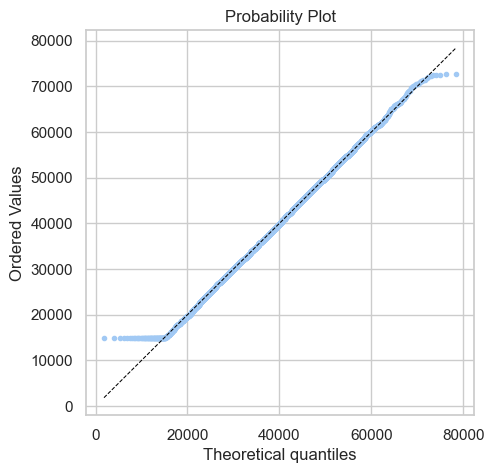

(alpha_gen)args:  (13.952422637465588, -103123.12713959778, 1989587.7768754428)


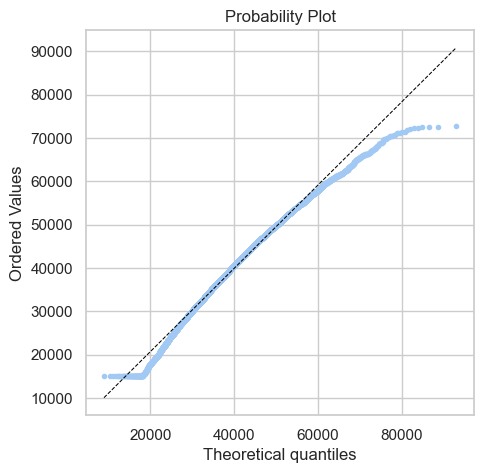

(gamma_gen)args:  (1790.645805148325, -385690.5076572277, 237.81755308561497)


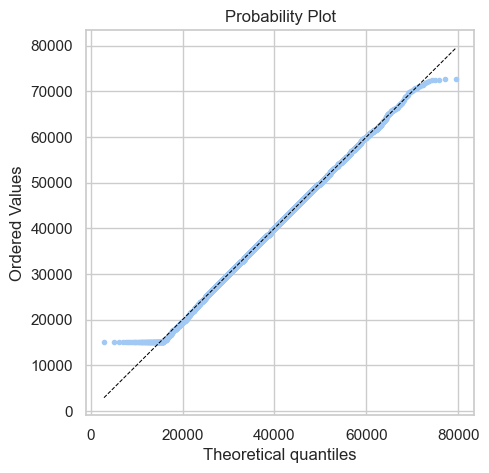

(beta_gen)args:  (14.913152522102813, 17.46605122813158, -13578.062781652796, 116668.10025947113)


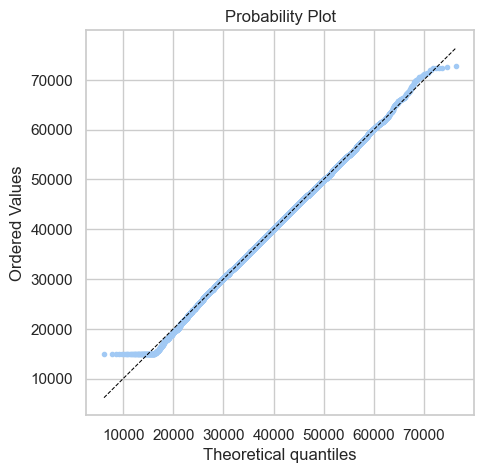

(norm_gen)args:  (31.685359906710485, 7.50151154917685)


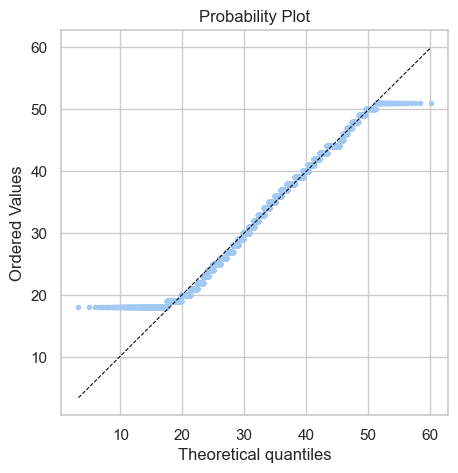

(alpha_gen)args:  (15.229098425522352, -83.1586227478573, 1741.5204915909308)


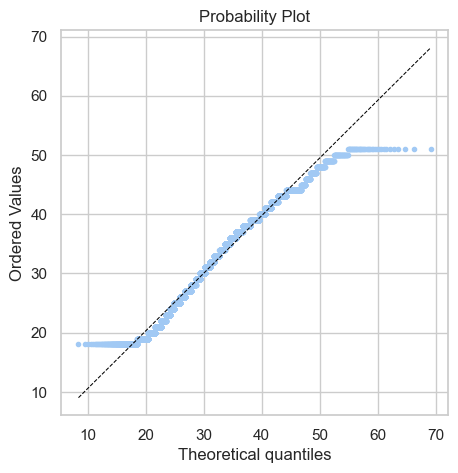

(gamma_gen)args:  (230.63094647524872, -82.09599225429704, 0.49330903920273406)


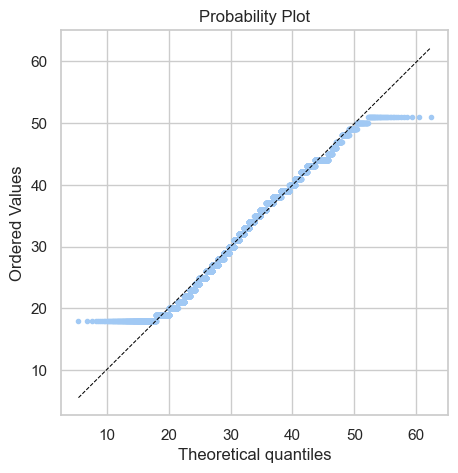

(beta_gen)args:  (1.6612266467443264, 2.3743500414978382, 17.11173074467363, 35.08412311113673)


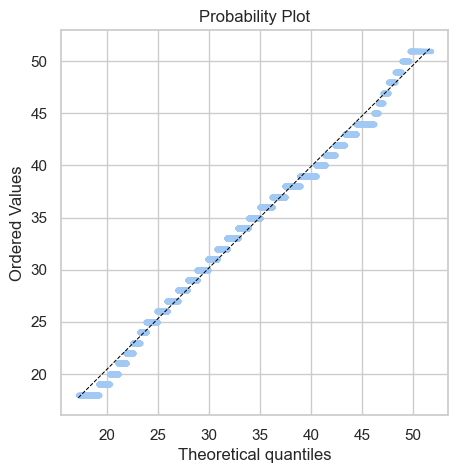

In [82]:
for m in methods.values():
    biplot(cut_tails(source_df.income, 15, 75), method=m)
    
for m in methods.values():
    biplot(cut_tails(source_df.age, 15, 60), method=m)

#### 7. Оценить достоверность подогнанных распределений, используя не менее 2 статистических тестов.

In [83]:
def testing(array, method, cdf):
    args = method.fit(array)

    tests = (scipy.stats.shapiro, scipy.stats.kstest, scipy.stats.anderson)

    result = [
        ("shapiro", scipy.stats.shapiro(array)),
        ("kstest", scipy.stats.kstest(array, cdf=cdf, args=args)),
        ("anderson", scipy.stats.anderson(array)),
        ("cramervonmises", scipy.stats.cramervonmises(array, cdf=cdf, args=args)),
    ]

    return result
            
    


In [84]:
correct_method = None
max_pvalue = 0
for name, method in methods.items():
    cdf = name[:-4]
    test_res = testing(cut_tails(source_df.income, 10, 75), method=method, cdf=cdf)
    for k in test_res:
        try:
            if max_pvalue < k[1].pvalue:
                max_pvalue = k[1].pvalue 
                correct_method = method
        except Exception:
            pass
        
        print(f"({name} - {k[0]}): {k[1]}")
print(max_pvalue, correct_method)

(norm_gen - shapiro): ShapiroResult(statistic=0.9984573721885681, pvalue=2.6707526856739605e-08)
(norm_gen - kstest): KstestResult(statistic=0.007336258193638645, pvalue=0.6565494769994902)
(norm_gen - anderson): AndersonResult(statistic=0.5875301719879644, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(norm_gen - cramervonmises): CramerVonMisesResult(statistic=0.06547683670702295, pvalue=0.7795959102079223)
(alpha_gen - shapiro): ShapiroResult(statistic=0.9984573721885681, pvalue=2.6707526856739605e-08)
(alpha_gen - kstest): KstestResult(statistic=0.023629233328217758, pvalue=3.0192570479366917e-05)
(alpha_gen - anderson): AndersonResult(statistic=0.5875301719879644, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(alpha_gen - cramervonmises): CramerVonMisesResult(statistic=1.9935704465956305, pvalue=1.3193705626357577e-05)
(gamma_gen - shapiro)

In [85]:
correct_method = None
max_pvalue = 0
for name, method in methods.items():
    cdf = name[:-4]
    test_res = testing(cut_tails(source_df.age, 10, 75), method=method, cdf=cdf)
    for k in test_res:
        try:
            if max_pvalue < k[1].pvalue:
                max_pvalue = k[1].pvalue 
                correct_method = method
        except Exception:
            pass
        
        print(f"({name} - {k[0]}): {k[1]}")
print(max_pvalue, correct_method)

(norm_gen - shapiro): ShapiroResult(statistic=0.9542423486709595, pvalue=0.0)
(norm_gen - kstest): KstestResult(statistic=0.06848526306711089, pvalue=5.112886382456654e-41)
(norm_gen - anderson): AndersonResult(statistic=78.56565159874299, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(norm_gen - cramervonmises): CramerVonMisesResult(statistic=8.78839961417781, pvalue=1.703195362523502e-10)
(alpha_gen - shapiro): ShapiroResult(statistic=0.9542423486709595, pvalue=0.0)
(alpha_gen - kstest): KstestResult(statistic=0.049639271965821186, pvalue=9.595575882960444e-22)
(alpha_gen - anderson): AndersonResult(statistic=78.56565159874299, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(alpha_gen - cramervonmises): CramerVonMisesResult(statistic=3.7971290709597203, pvalue=1.3968973755495995e-09)
(gamma_gen - shapiro): ShapiroResult(statistic=0.95424234867

#### 8. Используя одномерные параметрические распределения, которые были подобраны, выполните семплирование СВ. Используйте для этого не менее 2 различных методов семплирования.

Distribution beta_gen arguments: (24.024121512746337, 32.7852731266261, -25669.49961597193, 155741.07379703718)
24.024121512746337 32.7852731266261 -25669.49961597193 155741.07379703718


<AxesSubplot:title={'center':'accept-reject'}, ylabel='Density'>

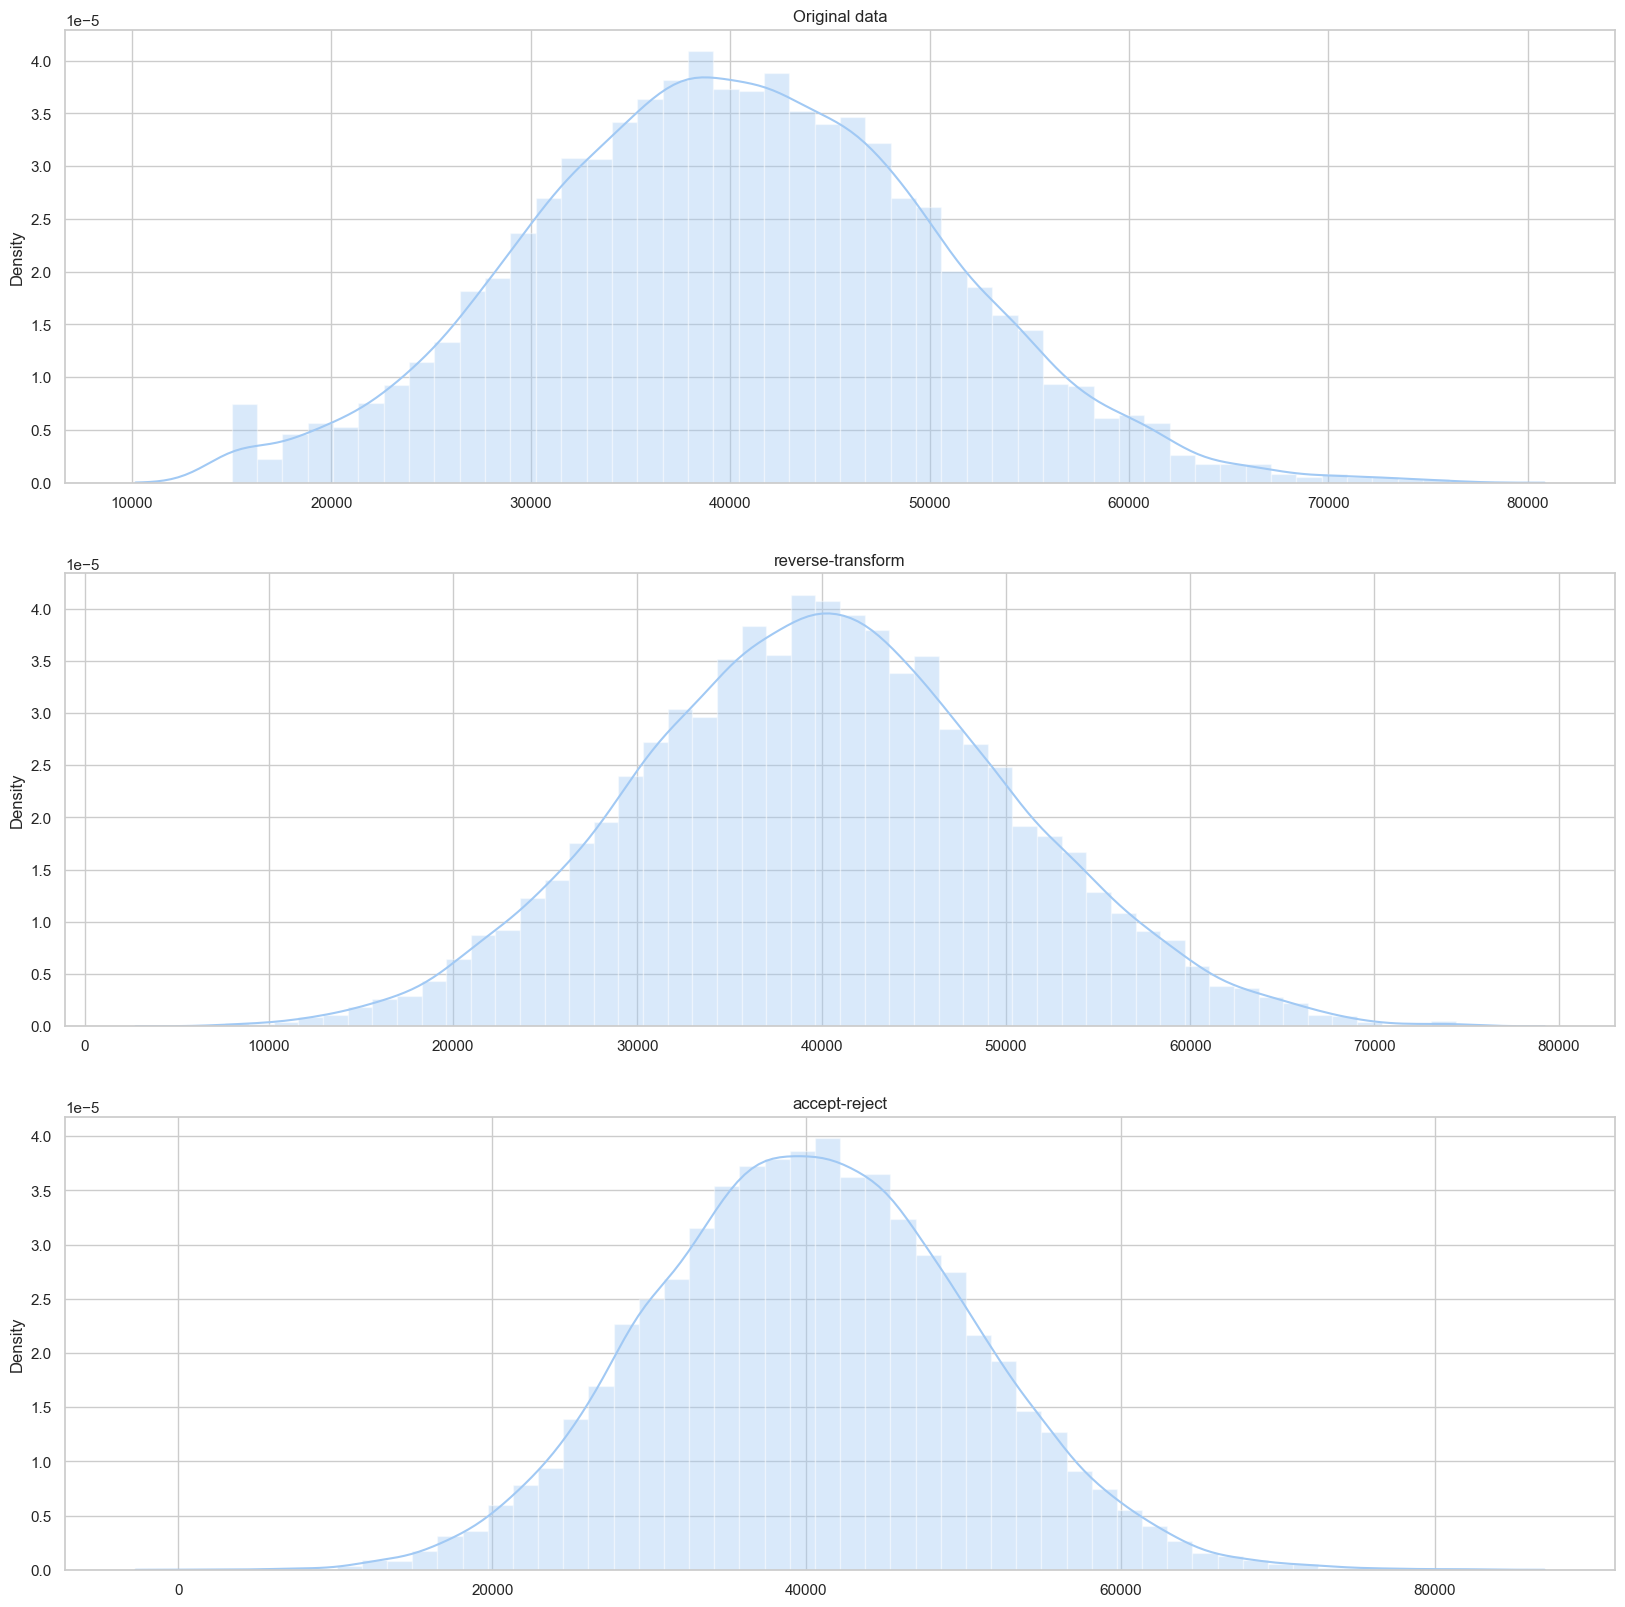

In [86]:
def rt_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample = sample.ppf(data)
    return sample


def ar_sampling(array, distribution):
    dstr = distribution.fit(array)
    print(*dstr)
    sample = distribution.rvs(*dstr, size=len(array))
    return sample

sns.set_theme(style='whitegrid', palette='pastel')
figure, ax = plt.subplots(3,1, figsize=(20, 20))
ax[0].set_title("Original data")
ax[1].set_title("reverse-transform")
ax[2].set_title("accept-reject")

tmp_df = cut_tails(source_df.income, 10, 75)
sns.distplot(tmp_df, ax=ax[0], kde=True)
sns.distplot(rt_sampling(tmp_df, scipy.stats.beta), ax=ax[1], kde=True)
sns.distplot(ar_sampling(tmp_df, scipy.stats.beta), ax=ax[2], kde=True)

# Семплирование возрастов

AxesSubplot(0.125,0.11;0.775x0.77)


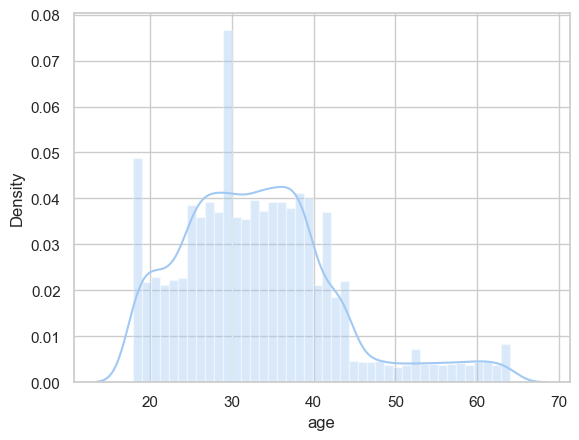

In [87]:

import scipy.stats as st

class my_pdf(st.rv_continuous):
    def _pdf(self,x):
        return 3*x**2  # Normalized over its range, in this case [0,1]

my_cv = my_pdf(a=0, b=1, name='my_pdf')

def ar_sampling(tmp_df, kde_values):
    np.random.seed(0)
    x = np.random.uniform(tmp_df.min(), tmp_df.max(), 10000)
    y = np.random.uniform(tmp_df.min(), tmp_df.max(), 10000)
    pdf = sns.distplot(tmp_df)
    print(pdf)    

df_empl = source_df.age

kernel = scipy.stats.gaussian_kde(df_empl)

min_price, max_price = df_empl.min(), df_empl.max()
x = np.linspace(min_price, max_price, len(df_empl))
kde_values = kernel.evaluate(x)

ar_sampling(df_empl, kde_values)

In [88]:
# percs = np.linspace(0, 100, len(source_df))
# qn_first = np.percentile(source_df.income, percs)
# qn_second = np.percentile(ar_sampling(source_df.income, scipy.stats.beta), percs)
# plt.figure(figsize=(12, 12))

# min_qn = np.min([qn_first.min(), qn_second.min()])
# max_qn = np.max([qn_first.max(), qn_second.max()])
# x = np.linspace(min_qn, max_qn)

# plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
# plt.plot(x, x, color="k", ls="--")

# plt.xlabel(u'Real')
# plt.ylabel(u'Sample')

In [89]:
# percs = np.linspace(0, 100, len(source_df))
# qn_first = np.percentile(source_df.age, percs)
# qn_second = np.percentile(ar_sampling(source_df.age, scipy.stats.beta), percs)
# plt.figure(figsize=(12, 12))

# min_qn = np.min([qn_first.min(), qn_second.min()])
# max_qn = np.max([qn_first.max(), qn_second.max()])
# x = np.linspace(min_qn, max_qn)

# plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
# plt.plot(x, x, color="k", ls="--")

# plt.xlabel(u'Real')
# plt.ylabel(u'Sample')

# Анализ дискретной величины

Text(0, 0.5, 'Sample')

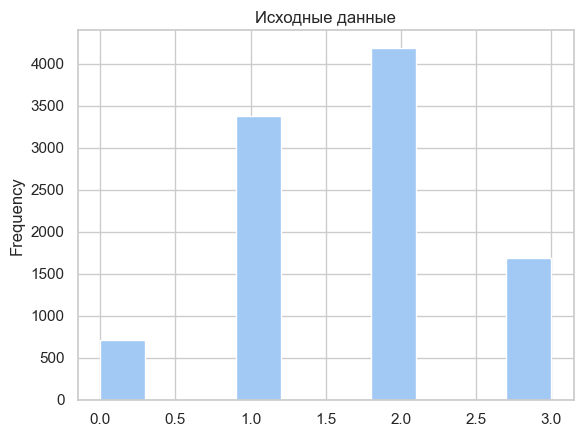

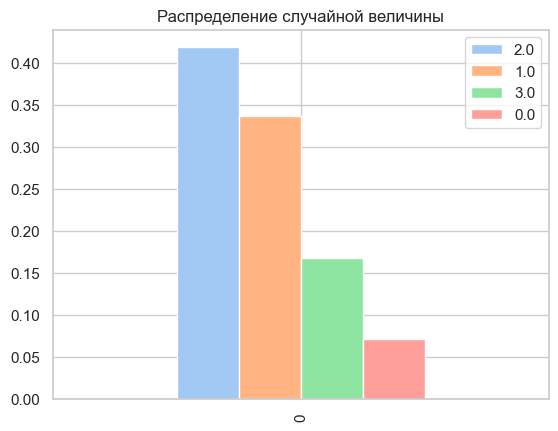

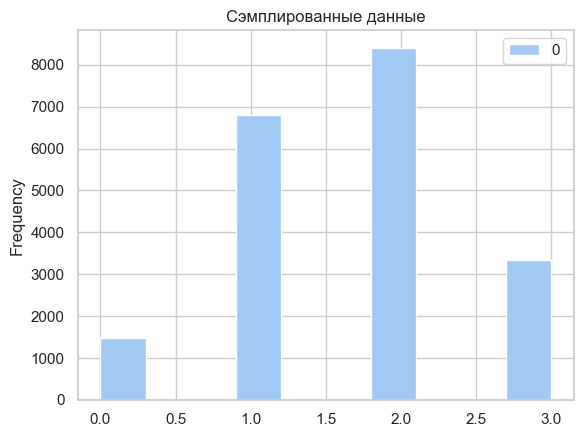

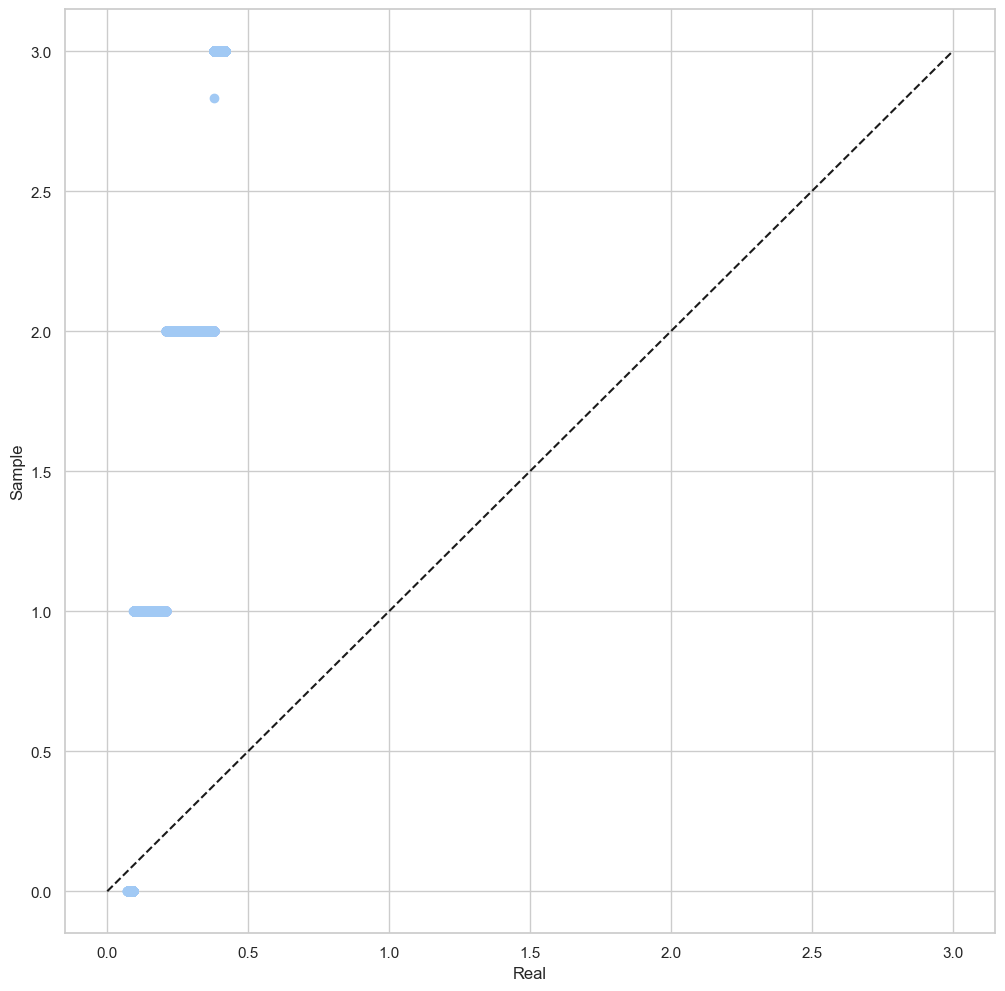

In [90]:
import random


def get_distribution(data):
    """Нахождение распределения дискретной величины"""
    unique_values = data.unique()[:-1]
    pdf = {}
    
    for u in unique_values:
        
        pdf[u] = [len(data.loc[source_df["education_level"] == u])/len(data)]
    
    return pdf


def sampling(data):
    """Семлпирование дискретной величины"""
    dstr = get_distribution(source_df.education_level)
    dist = [v[0] for v in dstr.values()]
    vals = [k for k in dstr.keys()]
    # print(vals, dist) 
    N = 20000
    sample = []
    for i in range(N):
        rindex = 0
        random.seed()
        lbound = 0
        ubound = 0
        rand = random.random()
        for interval in range(len(dist)):
            ubound += dist[interval]
            if lbound <= rand < ubound:
                rindex = interval
                break
            else:
                lbound = ubound
        sample.append(vals[rindex])
    return sample
        
    
source_df.education_level.plot(kind="hist", title="Исходные данные")
new_data = sampling(source_df.education_level)
d = pd.DataFrame(new_data)
distr = pd.DataFrame(get_distribution(source_df.education_level))
distr.plot(kind="bar", title="Распределение случайной величины")
d.plot(kind="hist", title="Сэмплированные данные")

percs = np.linspace(0, 100, len(source_df.education_level))
qn_first = np.percentile(distr, percs)
qn_second = np.percentile(d[0], percs)

plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Sample')
